## Escolher a doença

In [1902]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor


In [ ]:
#rodri
diagnoses = pd.read_csv('C:/Users/rodri/Downloads/DIAGNOSES_ICD.csv')
d_icd = pd.read_csv('C:/Users/rodri/Downloads/D_ICD_DIAGNOSES.csv')
chart_events = pd.read_csv('C:/Users/rodri/Downloads/CHARTEVENTS.csv')
lab_events = pd.read_csv('C:/Users/rodri/Downloads/LABEVENTS.csv')
admissions = pd.read_csv('C:/Users/rodri/Downloads/ADMISSIONS.csv')
icustays = pd.read_csv('C:/Users/rodri/Downloads/ICUSTAYS.csv')
inputevents_mv = pd.read_csv('C:/Users/rodri/Downloads/INPUTEVENTS_MV.csv')
inputevents_cv = pd.read_csv('C:/Users/rodri/Downloads/INPUTEVENTS_CV.csv')
patients = pd.read_csv('C:/Users/rodri/Downloads/PATIENTS.csv')
items = pd.read_csv('C:/Users/rodri/Downloads/D_ITEMS.csv')
labitems = pd.read_csv('C:/Users/rodri/Downloads/D_LABITEMS.csv')

#babs
# diagnoses = pd.read_csv('DIAGNOSES_ICD.csv')
# d_icd = pd.read_csv('D_ICD_DIAGNOSES.csv')
# chart_events = pd.read_csv('chart_events_filtered.csv')
# lab_events = pd.read_csv('lab_events_filtered.csv')
# admissions = pd.read_csv('admissions_filtered.csv')
# icustays = pd.read_csv('icustays_filtered.csv')
# inputevents_mv = pd.read_csv('inputevents_mv_filtered.csv')
# inputevents_cv = pd.read_csv('inputevents_cv_filtered.csv')
# patients = pd.read_csv('patients_filtered.csv')
# items = pd.read_csv('D_ITEMS.csv')
# labitems = pd.read_csv('D_LABITEMS.csv')

In [1904]:
diagnoses_primary = diagnoses[diagnoses['SEQ_NUM'] == 1]

icd9_counts_primary = diagnoses_primary['ICD9_CODE'].value_counts()

icd9_counts_filtered = icd9_counts_primary[(icd9_counts_primary >= 400) & (icd9_counts_primary <= 1000)]

print(icd9_counts_filtered)


ICD9_CODE
V3101    998
486      725
5070     659
4280     570
4240     568
430      529
5849     526
41041    482
41011    482
5789     446
Name: count, dtype: int64


In [1905]:
#codigo da doença escolhida é 486
diagnoses_inf = diagnoses[diagnoses['ICD9_CODE'] == '486']

disease_info = d_icd[d_icd['ICD9_CODE'] == '486']  
print(disease_info[['ICD9_CODE', 'SHORT_TITLE', 'LONG_TITLE']])

count_seq1 = diagnoses_inf[diagnoses_inf['SEQ_NUM'] == 1].shape[0]
print(count_seq1)

     ICD9_CODE              SHORT_TITLE                       LONG_TITLE
5147       486  Pneumonia, organism NOS  Pneumonia, organism unspecified
725


Criar tabela com outras duas colunas da segnda e terceira doença

In [1906]:
diagnoses_inf = diagnoses[(diagnoses['ICD9_CODE'] == '486') & (diagnoses['SEQ_NUM'] == 1)]
diagnoses_seq2 = diagnoses[diagnoses['SEQ_NUM'] == 2][['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']].rename(columns={'ICD9_CODE': 'ICD9_CODE_2'})
diagnoses_seq3 = diagnoses[diagnoses['SEQ_NUM'] == 3][['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']].rename(columns={'ICD9_CODE': 'ICD9_CODE_3'})

merged = diagnoses_inf.merge(diagnoses_seq2, on=['SUBJECT_ID', 'HADM_ID'], how='left')
merged = merged.merge(diagnoses_seq3, on=['SUBJECT_ID', 'HADM_ID'], how='left')
tabela = merged[['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE', 'ICD9_CODE_2', 'ICD9_CODE_3']]

hadm_ids = tabela['HADM_ID'].unique()
subject_ids = tabela['SUBJECT_ID'].unique()

icustays = icustays[icustays['HADM_ID'].isin(hadm_ids)]


tabela = icustays.merge(
    tabela,
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'
)
tabela = tabela[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ICD9_CODE', 'ICD9_CODE_2', 'ICD9_CODE_3']] 

# Verifique o resultado
print(tabela.shape)  # Deve ser (763, n_colunas)
print(tabela.head())


(763, 6)
   SUBJECT_ID  HADM_ID  ICUSTAY_ID ICD9_CODE ICD9_CODE_2 ICD9_CODE_3
0         346   195392      260798       486       42731        4241
1         111   192123      254245       486       49121        4139
2         242   192980      270389       486         496       51889
3         357   117876      235292       486        3453        5722
4         368   105889      242607       486       49121       41071


In [1907]:
hadm_ids = tabela['HADM_ID'].unique()
icu_ids = tabela['ICUSTAY_ID'].unique()
subject_ids = tabela['SUBJECT_ID'].unique()

chart_events_filtered = chart_events[chart_events['ICUSTAY_ID'].isin(icu_ids)]
lab_events_filtered = lab_events[lab_events['HADM_ID'].isin(hadm_ids)]
admissions_filtered = admissions[admissions['HADM_ID'].isin(hadm_ids)]
icustays_filtered = icustays[icustays['ICUSTAY_ID'].isin(icu_ids)]
inputevents_mv_filtered = inputevents_mv[inputevents_mv['ICUSTAY_ID'].isin(icu_ids)]
inputevents_cv_filtered = inputevents_cv[inputevents_cv['ICUSTAY_ID'].isin(icu_ids)]
patients_filtered = patients[patients['SUBJECT_ID'].isin(subject_ids)]


# chart_events_filtered.to_csv('chart_events_filtered.csv', index=False)
# lab_events_filtered.to_csv('lab_events_filtered.csv', index=False)
# admissions_filtered.to_csv('admissions_filtered.csv', index=False)
# icustays_filtered.to_csv('icustays_filtered.csv', index=False)
# inputevents_mv_filtered.to_csv('inputevents_mv_filtered.csv', index=False)
# inputevents_cv_filtered.to_csv('inputevents_cv_filtered.csv', index=False)
# patients_filtered.to_csv('patients_filtered.csv', index=False)

In [1908]:
#download das tabelas filtradas, usar sempre a partir daqui
chart_events = pd.read_csv('C:/Users/rodri/OneDrive/Ambiente de Trabalho/Matemática Rodrigo/Mestrado/2ºsemestre/ML/Projeto2/chart_events_filtered.csv')
lab_events = pd.read_csv('C:/Users/rodri/OneDrive/Ambiente de Trabalho/Matemática Rodrigo/Mestrado/2ºsemestre/ML/Projeto2/lab_events_filtered.csv')
admissions = pd.read_csv('C:/Users/rodri/OneDrive/Ambiente de Trabalho/Matemática Rodrigo/Mestrado/2ºsemestre/ML/Projeto2/admissions_filtered.csv')
icustays = pd.read_csv('C:/Users/rodri/OneDrive/Ambiente de Trabalho/Matemática Rodrigo/Mestrado/2ºsemestre/ML/Projeto2/icustays_filtered.csv')
input_cv = pd.read_csv('C:/Users/rodri/OneDrive/Ambiente de Trabalho/Matemática Rodrigo/Mestrado/2ºsemestre/ML/Projeto2/inputevents_cv_filtered.csv')
input_mv = pd.read_csv('C:/Users/rodri/OneDrive/Ambiente de Trabalho/Matemática Rodrigo/Mestrado/2ºsemestre/ML/Projeto2/inputevents_mv_filtered.csv')
d_items = pd.read_csv('C:/Users/rodri/Downloads/D_ITEMS.csv')
labitems = pd.read_csv('C:/Users/rodri/Downloads/D_LABITEMS.csv')
patients = pd.read_csv('C:/Users/rodri/OneDrive/Ambiente de Trabalho/Matemática Rodrigo/Mestrado/2ºsemestre/ML/Projeto2/patients_filtered.csv')
diagnoses = pd.read_csv('C:/Users/rodri/Downloads/DIAGNOSES_ICD.csv')
d_icd = pd.read_csv('C:/Users/rodri/Downloads/D_ICD_DIAGNOSES.csv')

C:\Users\rodri\AppData\Local\Temp\ipykernel_33472\3561195554.py:2: DtypeWarning: Columns (8,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  chart_events = pd.read_csv('C:/Users/rodri/OneDrive/Ambiente de Trabalho/Matemática Rodrigo/Mestrado/2ºsemestre/ML/Projeto2/chart_events_filtered.csv')
C:\Users\rodri\AppData\Local\Temp\ipykernel_33472\3561195554.py:6: DtypeWarning: Columns (9,17,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  input_cv = pd.read_csv('C:/Users/rodri/OneDrive/Ambiente de Trabalho/Matemática Rodrigo/Mestrado/2ºsemestre/ML/Projeto2/inputevents_cv_filtered.csv')


## Análise geral da doença

### Icustays

=== STATISTICAL SUMMARY ===
Total ICU admissions: 763
Intensive care units represented: 5

Length of Stay distribution (days):
count    763.000000
mean       3.861453
std        4.755012
min        0.027951
25%        1.211753
50%        2.141609
75%        4.270422
max       41.557639
Name: LOS, dtype: float64


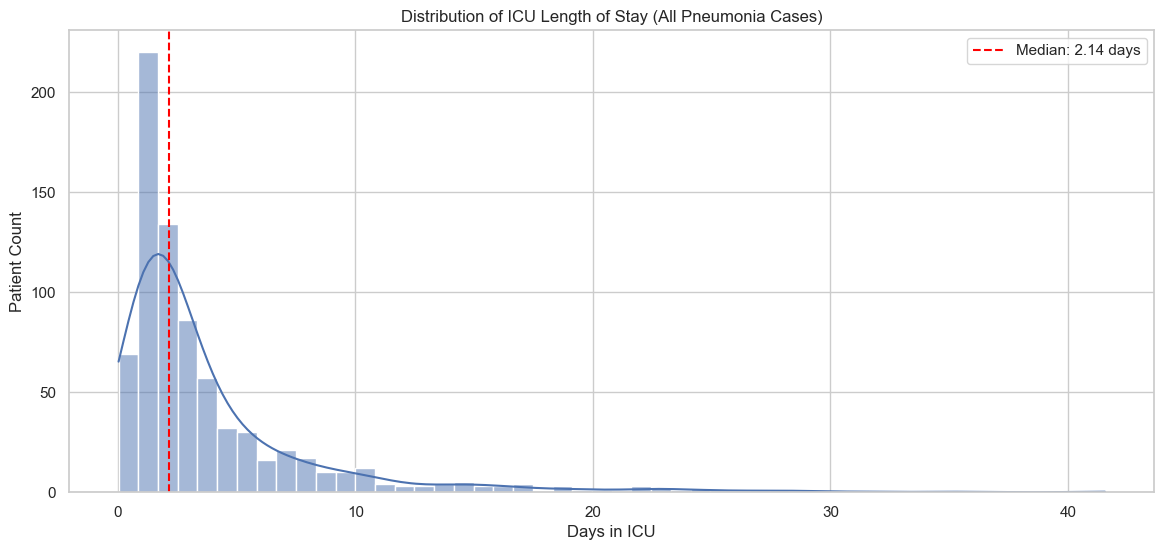

In [1909]:
#icustays
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])
icustays['OUTTIME'] = pd.to_datetime(icustays['OUTTIME'])
icustays['LOS'] = (icustays['OUTTIME'] - icustays['INTIME']).dt.total_seconds() / 3600 / 24  # in days

# Basic Descriptive Analysis
print("=== STATISTICAL SUMMARY ===")
print(f"Total ICU admissions: {len(icustays)}")
print(f"Intensive care units represented: {icustays['LAST_CAREUNIT'].nunique()}")
print("\nLength of Stay distribution (days):")
print(icustays['LOS'].describe())

# LOS Distribution Visualization
plt.figure(figsize=(14, 6))
sns.histplot(data=icustays, x='LOS', bins=50, kde=True)
plt.title('Distribution of ICU Length of Stay (All Pneumonia Cases)')
plt.xlabel('Days in ICU')
plt.ylabel('Patient Count')
plt.axvline(x=icustays['LOS'].median(), color='red', linestyle='--', label=f'Median: {icustays["LOS"].median():.2f} days')
plt.legend()
plt.show()

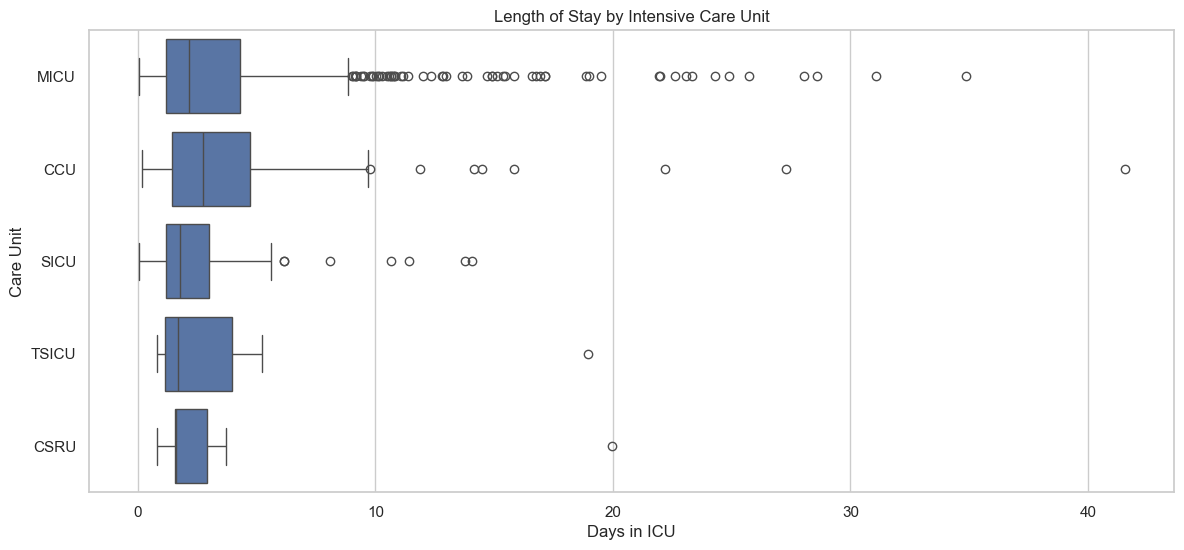

In [1910]:
# Analysis by Care Unit
plt.figure(figsize=(14, 6))
sns.boxplot(data=icustays, x='LOS', y='LAST_CAREUNIT', order=icustays['LAST_CAREUNIT'].value_counts().index)
plt.title('Length of Stay by Intensive Care Unit')
plt.xlabel('Days in ICU')
plt.ylabel('Care Unit')
plt.show()

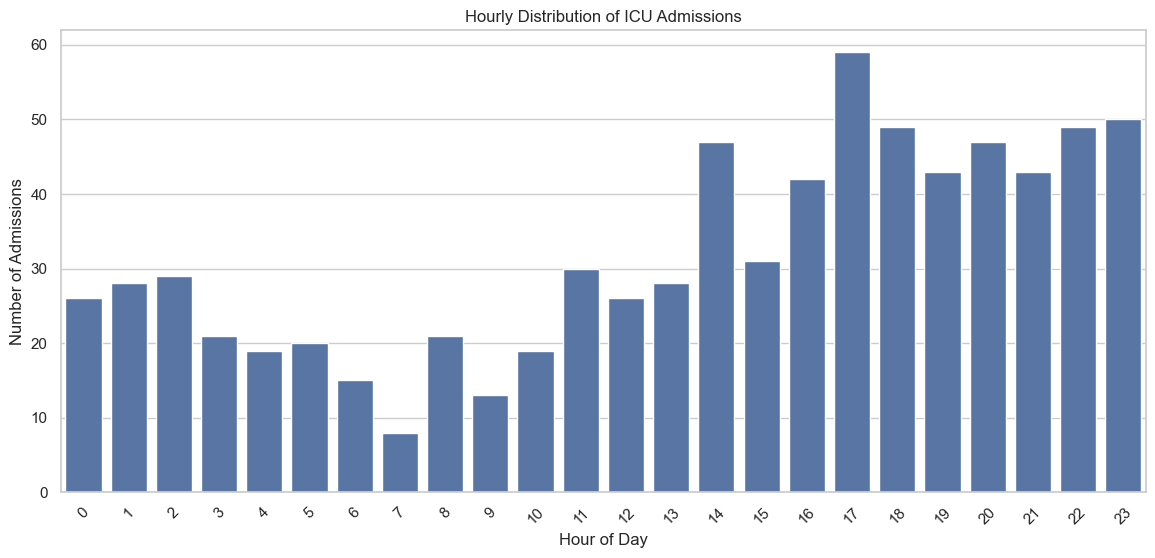

In [1911]:
# Temporal Pattern of Admissions
icustays['ADMIT_HOUR'] = icustays['INTIME'].dt.hour
plt.figure(figsize=(14, 6))
sns.countplot(data=icustays, x='ADMIT_HOUR')
plt.title('Hourly Distribution of ICU Admissions')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Admissions')
plt.xticks(rotation=45)
plt.show()

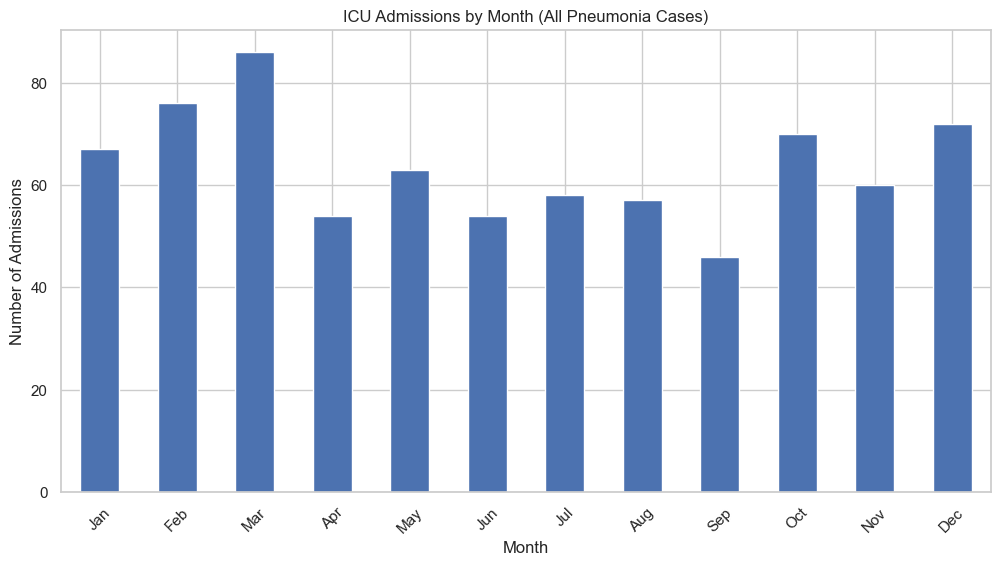

In [1912]:
# Seasonality Analysis
icustays['ADMIT_MONTH'] = icustays['INTIME'].dt.month
monthly_admits = icustays['ADMIT_MONTH'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
monthly_admits.plot(kind='bar')
plt.title('ICU Admissions by Month (All Pneumonia Cases)')
plt.xlabel('Month')
plt.ylabel('Number of Admissions')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

### Input events

=== INPUT EVENTS ANALYSIS ===
Total medication administrations: 191,612
Unique medication items: 273

Top 10 most administered items:
   ITEMID              LABEL  COUNT
0   30018  .9% Normal Saline  32909
1   30013                D5W  18761
2   30118           Fentanyl  13536
3   30124          Midazolam   8594
4   30131           Propofol   7534
5   30045            Insulin   6879
6  225158          NaCl 0.9%   6084
7  220949        Dextrose 5%   5303
8   30141             Ativan   4937
9   30025            Heparin   4933


C:\Users\rodri\AppData\Local\Temp\ipykernel_33472\1841494319.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


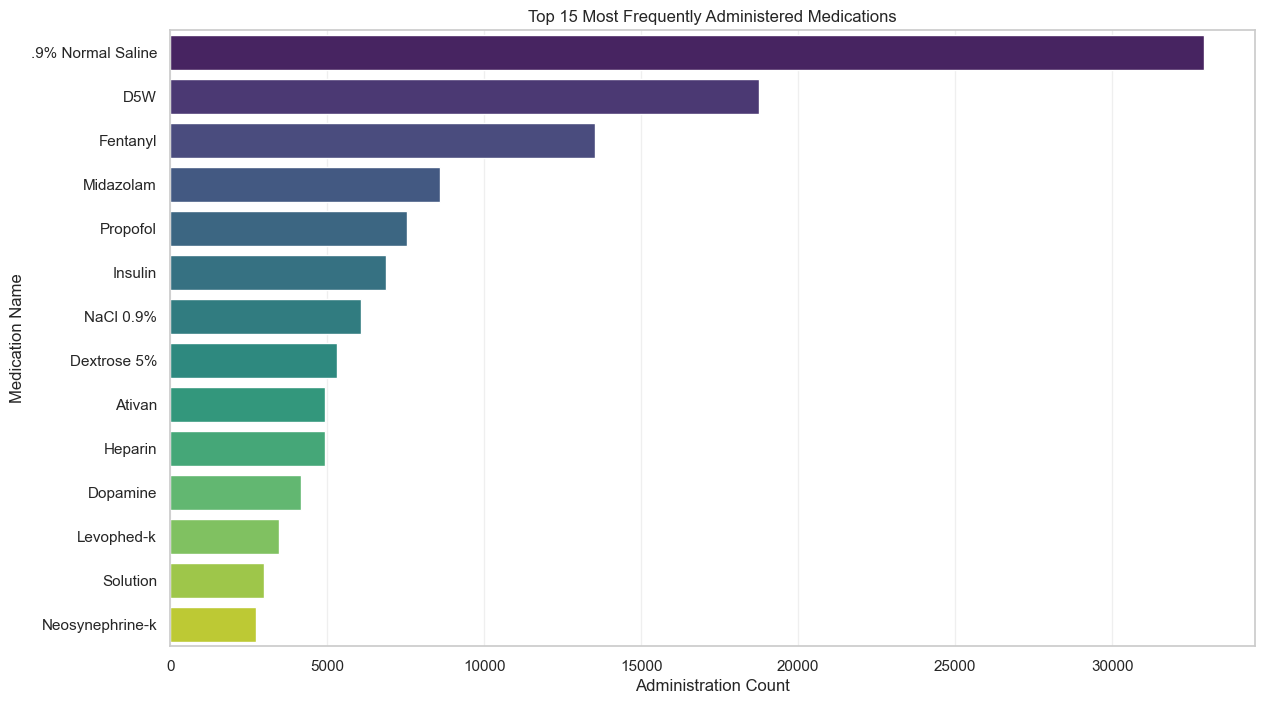

In [1913]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Visualization settings
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [14, 8]

# Merge input events with medication names
input_events = pd.concat([inputevents_cv, inputevents_mv]).merge(
    items[['ITEMID', 'LABEL']].drop_duplicates(), 
    on='ITEMID', 
    how='left'
)

# Convert timestamps
input_events['CHARTTIME'] = pd.to_datetime(input_events['CHARTTIME'])
input_events['STARTTIME'] = pd.to_datetime(input_events['STARTTIME'])
input_events['time'] = input_events['CHARTTIME'].fillna(input_events['STARTTIME'])

# Basic Descriptive Analysis
print("=== INPUT EVENTS ANALYSIS ===")
print(f"Total medication administrations: {len(input_events):,}")
print(f"Unique medication items: {input_events['ITEMID'].nunique()}")
print("\nTop 10 most administered items:")

# Get top items with counts and labels - CORRECTED APPROACH
top_items = (input_events['ITEMID'].value_counts()
            .reset_index(name='COUNT')
            .rename(columns={'index': 'ITEMID'})
            .head(10))

top_items_with_labels = top_items.merge(
    items[['ITEMID', 'LABEL']].drop_duplicates(),
    on='ITEMID',
    how='left'
)

print(top_items_with_labels[['ITEMID', 'LABEL', 'COUNT']])


# Medication Type Analysis with Labels
top_item_ids = input_events['ITEMID'].value_counts().head(15).index
top_items_with_labels = input_events[input_events['ITEMID'].isin(top_item_ids)]

plt.figure(figsize=(14, 8))
sns.countplot(
    data=top_items_with_labels,
    y='LABEL',
    order=top_items_with_labels['LABEL'].value_counts().index,
    palette='viridis'
)
plt.title('Top 15 Most Frequently Administered Medications')
plt.xlabel('Administration Count')
plt.ylabel('Medication Name')
plt.grid(True, axis='x', alpha=0.3)
plt.show()

C:\Users\rodri\AppData\Local\Temp\ipykernel_33472\304031496.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_items_with_labels['CHARTTIME'] = pd.to_datetime(top_items_with_labels['CHARTTIME'])
C:\Users\rodri\AppData\Local\Temp\ipykernel_33472\304031496.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_items_with_labels['hour'] = top_items_with_labels['CHARTTIME'].dt.hour


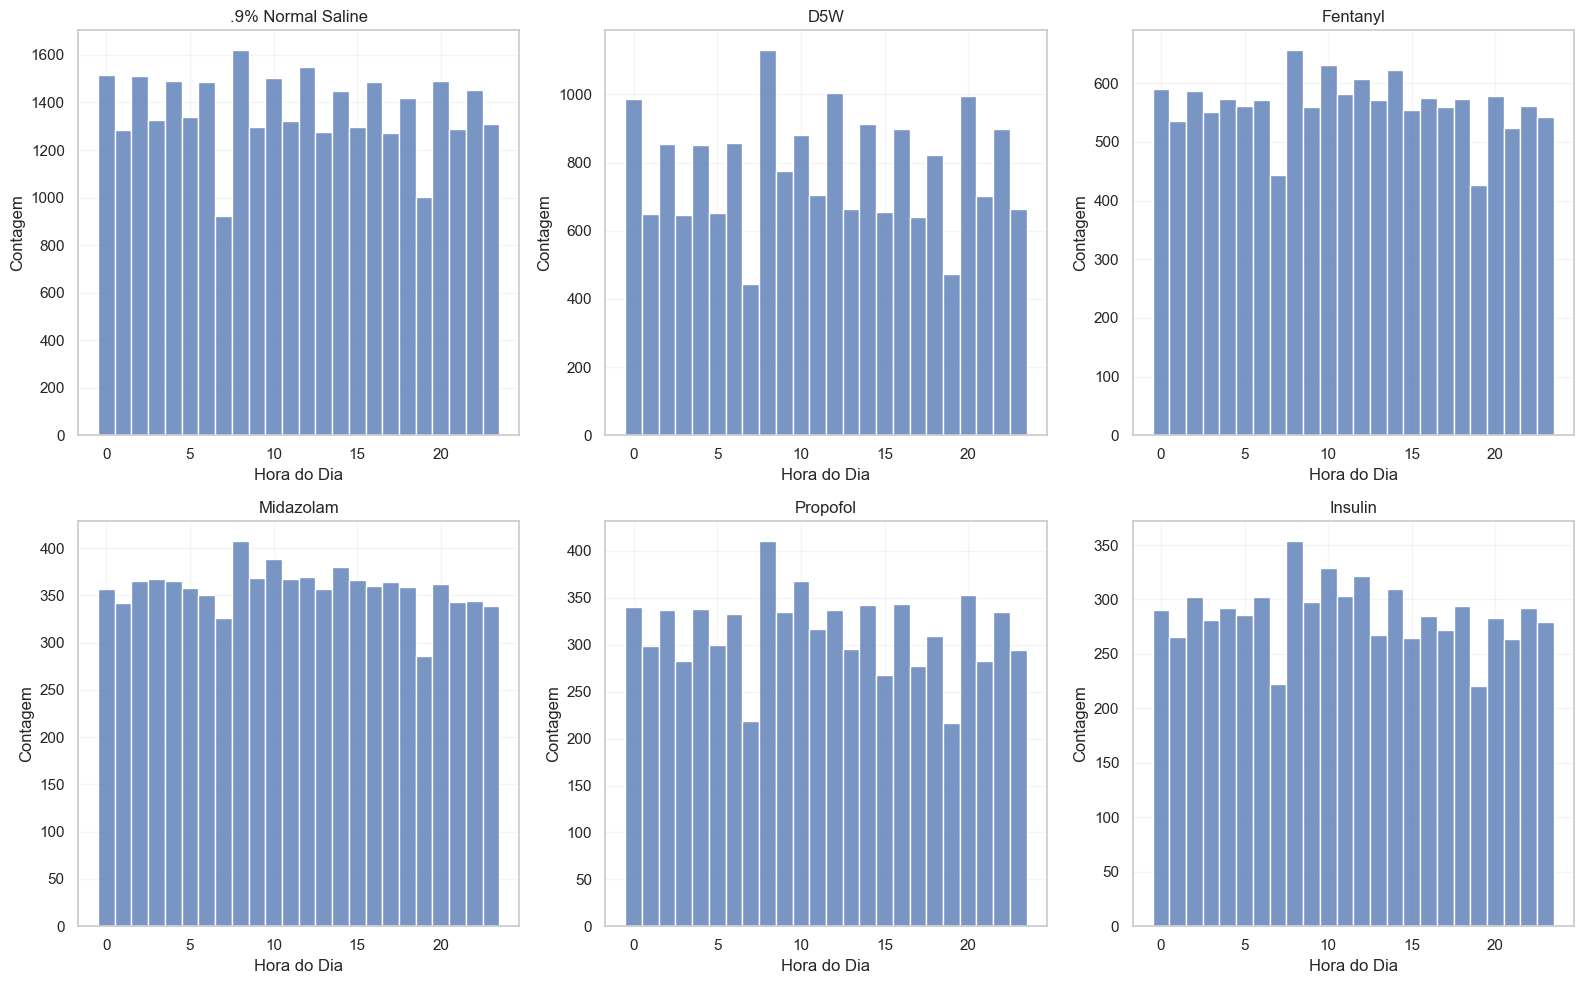

In [1914]:
# Certifique-se de que CHARTTIME está em datetime
top_items_with_labels['CHARTTIME'] = pd.to_datetime(top_items_with_labels['CHARTTIME'])

# Criar coluna com a hora do dia (0 a 23)
top_items_with_labels['hour'] = top_items_with_labels['CHARTTIME'].dt.hour

# Plotar histogramas para os 6 medicamentos mais frequentes
plt.figure(figsize=(16, 10))
top_6_labels = top_items_with_labels['LABEL'].value_counts().index[:6]

for i, item_label in enumerate(top_6_labels):
    plt.subplot(2, 3, i+1)
    item_data = top_items_with_labels[top_items_with_labels['LABEL'] == item_label]
    sns.histplot(data=item_data, x='hour', bins=24, discrete=True)
    plt.title(f'{item_label[:30]}' + ('...' if len(item_label) > 30 else ''))
    plt.xlabel('Hora do Dia')
    plt.ylabel('Contagem')
    plt.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

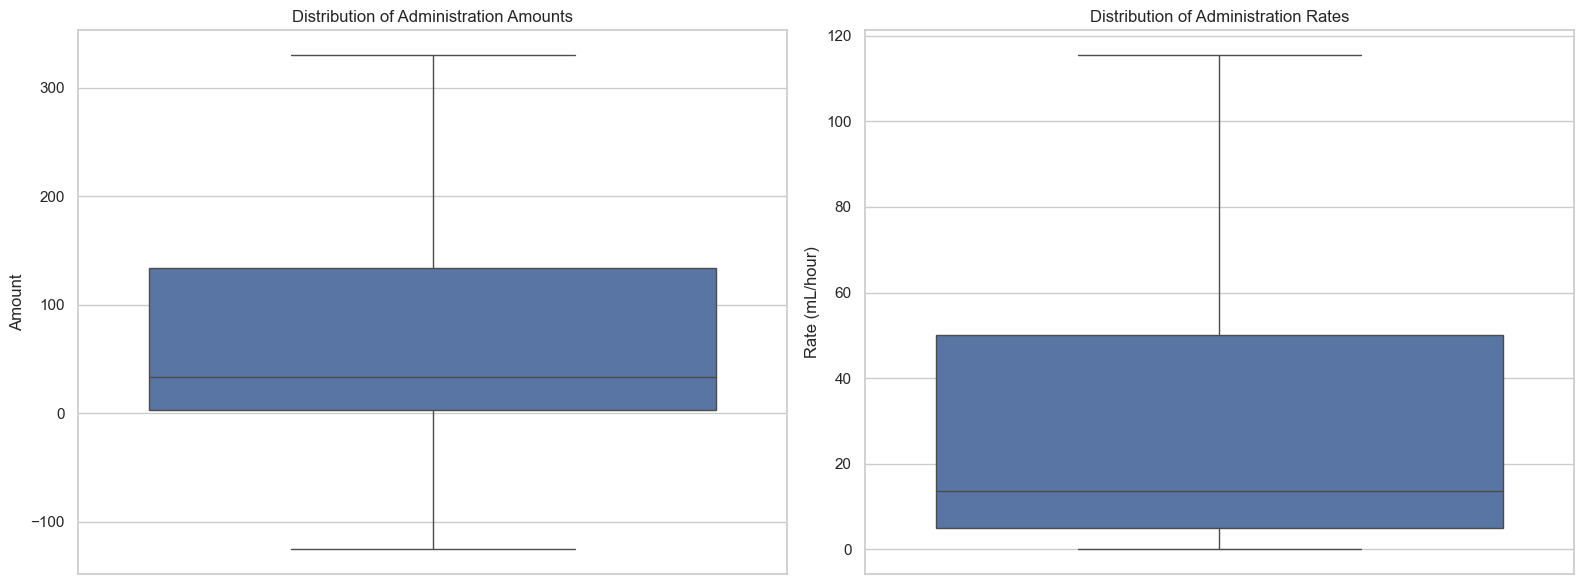

In [1915]:
# Rate and Amount Analysis
if all(col in input_events.columns for col in ['RATE', 'AMOUNT']):
    numeric_events = input_events.dropna(subset=['RATE', 'AMOUNT'])
    
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(data=numeric_events, y='AMOUNT', showfliers=False)
    plt.title('Distribution of Administration Amounts')
    plt.ylabel('Amount')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data=numeric_events, y='RATE', showfliers=False)
    plt.title('Distribution of Administration Rates')
    plt.ylabel('Rate (mL/hour)')
    plt.tight_layout()
    plt.show()

### lab events

=== LAB EVENTS ANALYSIS ===
Total lab tests performed: 278,197
Unique lab test items: 475

Top 10 most frequent lab tests:
   ITEMID           LABEL    CATEGORY  COUNT
0   50971       Potassium   Chemistry   8390
1   50983          Sodium   Chemistry   8139
2   50902        Chloride   Chemistry   8050
3   50912      Creatinine   Chemistry   8026
4   51006   Urea Nitrogen   Chemistry   8013
5   50882     Bicarbonate   Chemistry   7986
6   51221      Hematocrit  Hematology   7970
7   50868       Anion Gap   Chemistry   7959
8   50931         Glucose   Chemistry   7900
9   51265  Platelet Count  Hematology   7419


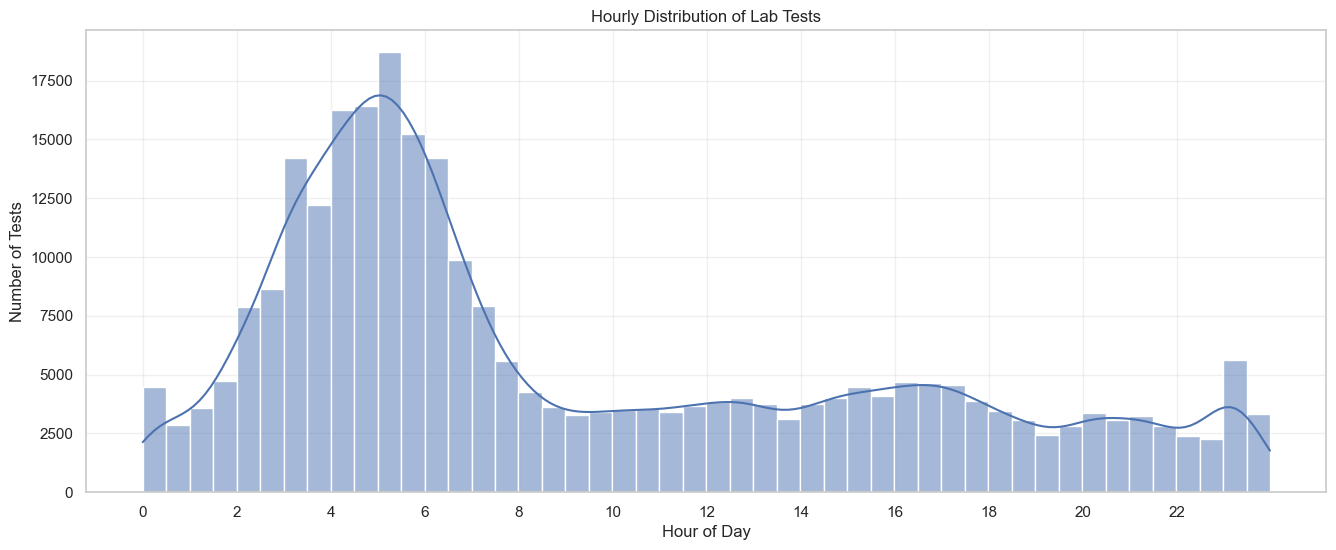

In [1916]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [14, 8]

labevents = lab_events.merge(
    labitems[['ITEMID', 'LABEL', 'FLUID', 'CATEGORY']].drop_duplicates(),
    on='ITEMID',
    how='left'
)

# Convert timestamps (adjust column names as needed)
if 'CHARTTIME' in labevents.columns:
    labevents['CHARTTIME'] = pd.to_datetime(labevents['CHARTTIME'])
    labevents['time'] = labevents['CHARTTIME']

# Basic Descriptive Analysis
print("=== LAB EVENTS ANALYSIS ===")
print(f"Total lab tests performed: {len(labevents):,}")
print(f"Unique lab test items: {labevents['ITEMID'].nunique()}")
print("\nTop 10 most frequent lab tests:")

# Get top lab tests with counts and labels
top_labtests = (labevents['ITEMID'].value_counts()
               .reset_index(name='COUNT')
               .rename(columns={'index': 'ITEMID'})
               .head(10)
               .merge(labitems[['ITEMID', 'LABEL', 'CATEGORY']].drop_duplicates(),
                    on='ITEMID',
                    how='left'))

print(top_labtests[['ITEMID', 'LABEL', 'CATEGORY', 'COUNT']])

# Temporal Distribution Analysis
if 'time' in labevents.columns:
    labevents['hour'] = labevents['time'].dt.hour + labevents['time'].dt.minute/60
    
    plt.figure(figsize=(16, 6))
    sns.histplot(data=labevents, x='hour', bins=48, kde=True)
    plt.title('Hourly Distribution of Lab Tests')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Tests')
    plt.xticks(np.arange(0, 24, 2))
    plt.grid(True, alpha=0.3)
    plt.show()


C:\Users\rodri\AppData\Local\Temp\ipykernel_33472\3504466910.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


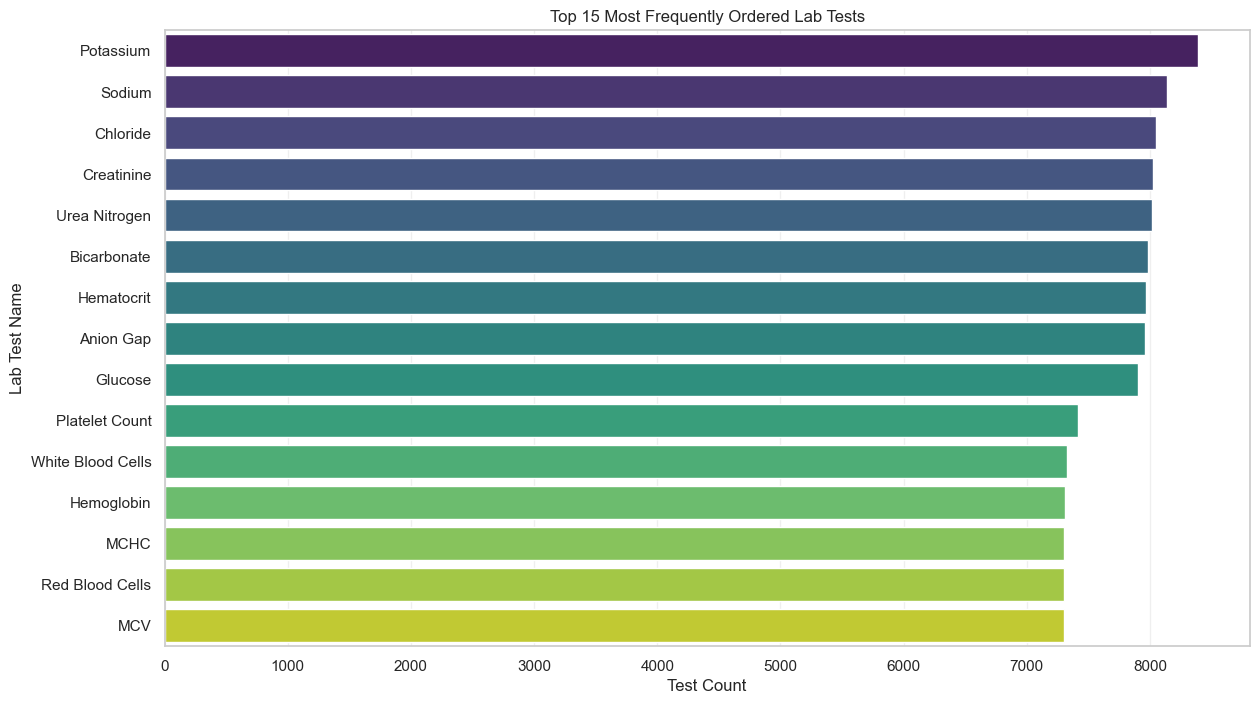

In [1917]:
# Lab Test Type Analysis with Labels
top_labtest_ids = labevents['ITEMID'].value_counts().head(15).index
top_labtests_with_labels = labevents[labevents['ITEMID'].isin(top_labtest_ids)]

plt.figure(figsize=(14, 8))
sns.countplot(
    data=top_labtests_with_labels,
    y='LABEL',
    order=top_labtests_with_labels['LABEL'].value_counts().index,
    palette='viridis'
)
plt.title('Top 15 Most Frequently Ordered Lab Tests')
plt.xlabel('Test Count')
plt.ylabel('Lab Test Name')
plt.grid(True, axis='x', alpha=0.3)
plt.show()

C:\Users\rodri\AppData\Local\Temp\ipykernel_33472\2607270047.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


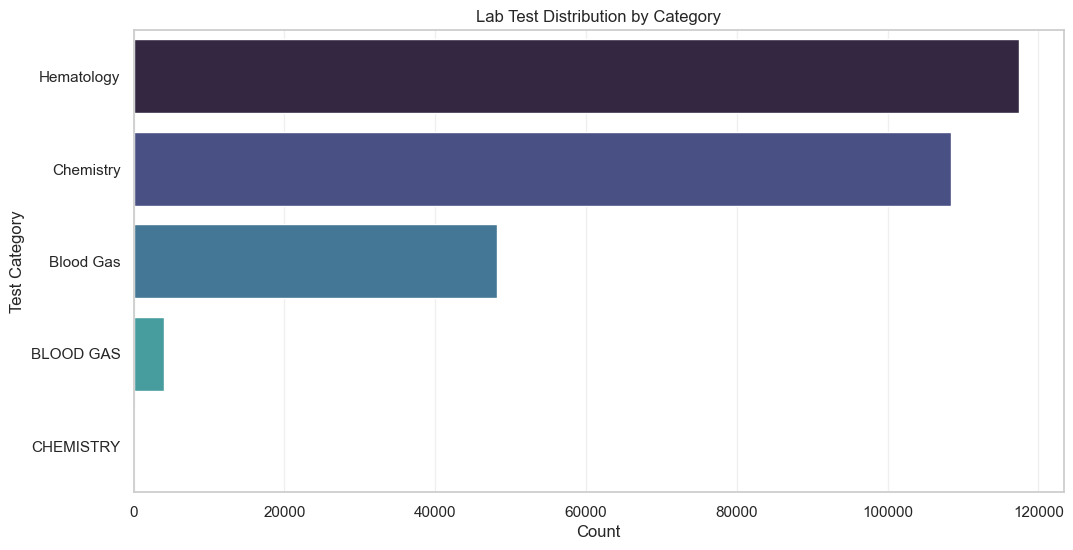

In [1918]:
# Analysis by Test Category
plt.figure(figsize=(12, 6))
sns.countplot(
    data=labevents,
    y='CATEGORY',
    order=labevents['CATEGORY'].value_counts().index,
    palette='mako'
)
plt.title('Lab Test Distribution by Category')
plt.xlabel('Count')
plt.ylabel('Test Category')
plt.grid(True, axis='x', alpha=0.3)
plt.show()

C:\Users\rodri\AppData\Local\Temp\ipykernel_33472\324611983.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


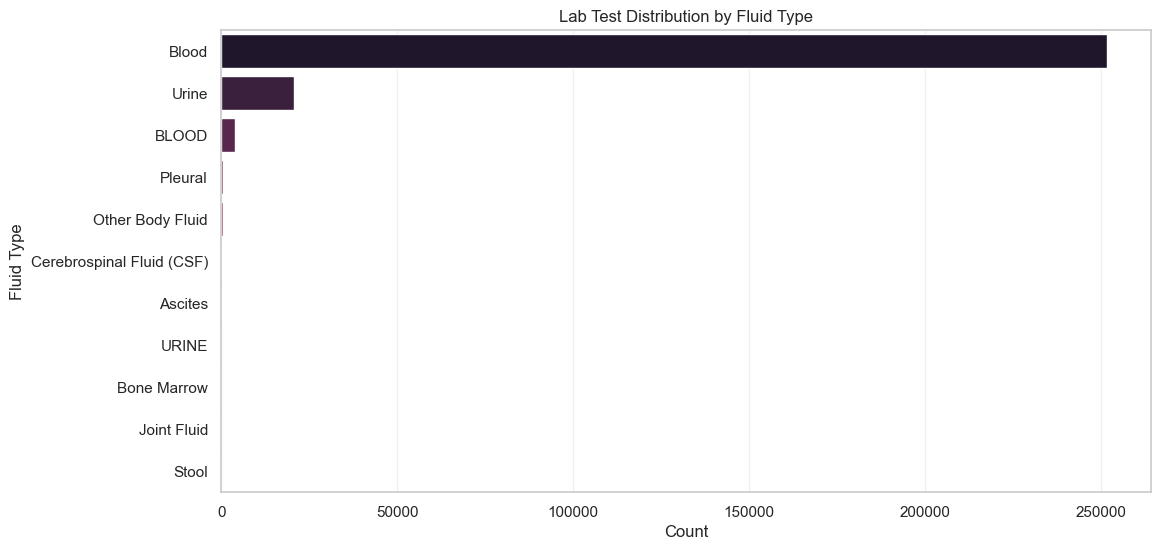

In [1919]:
# Analysis by Fluid Type
if 'FLUID' in labevents.columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(
        data=labevents,
        y='FLUID',
        order=labevents['FLUID'].value_counts().index,
        palette='rocket'
    )
    plt.title('Lab Test Distribution by Fluid Type')
    plt.xlabel('Count')
    plt.ylabel('Fluid Type')
    plt.grid(True, axis='x', alpha=0.3)
    plt.show()

agora seria fazer:

 -uma analise estatistica de cada paciente (sao muitos, entao provavelmente so de alguns)

 -machine learning para a variavel LOS no tabela icustays, mas as variáveis que importam estão no chart_events, inputevents_cv e inputevents_mv

C:\Users\rodri\AppData\Local\Temp\ipykernel_33472\2627215745.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[time_col] = pd.to_datetime(df[time_col])
C:\Users\rodri\AppData\Local\Temp\ipykernel_33472\2627215745.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hours_since_start'] = (df[time_col] - df[time_col].min()).dt.total_seconds() / 3600


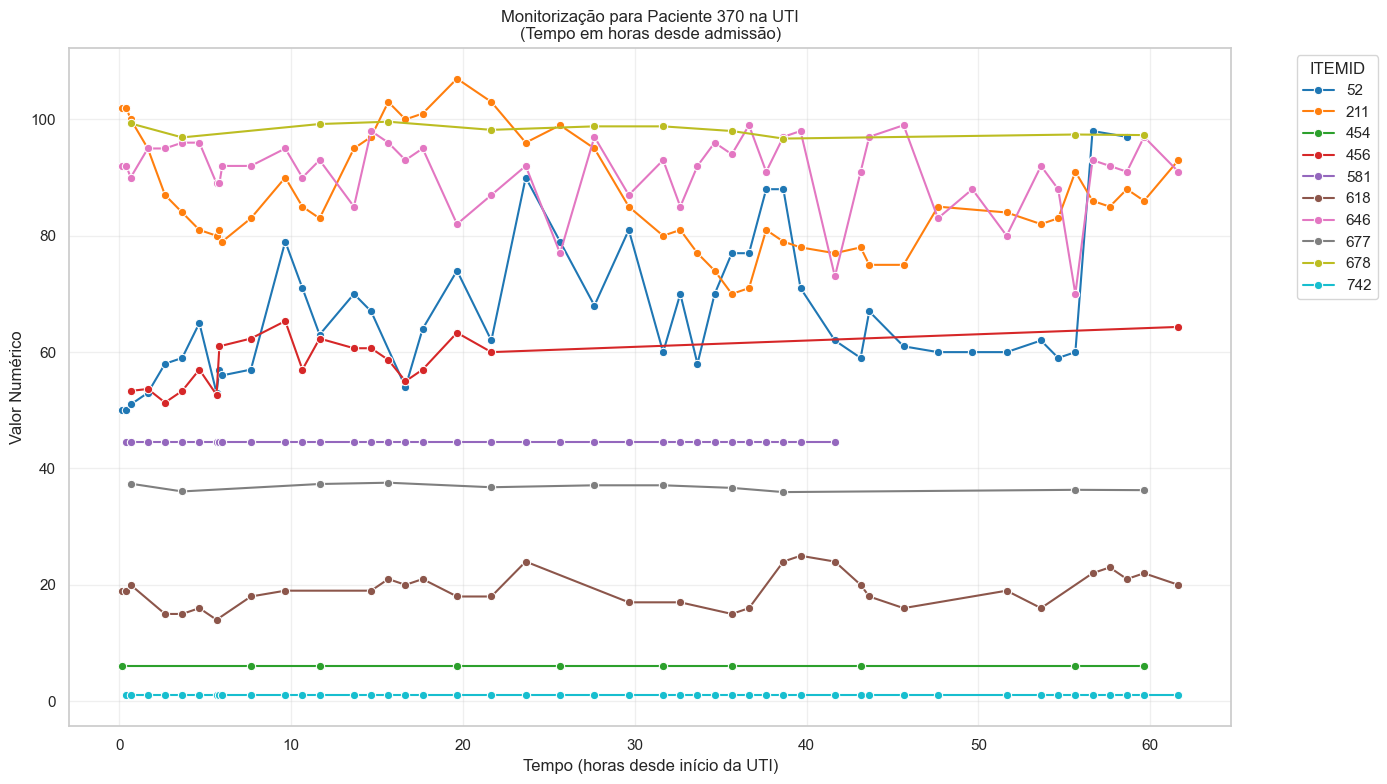

In [1920]:
#analise do paciente 804 
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [14, 8]

subject_id = 370
hadm_id = 123421
icustay_id = 228402

def convert_time_hours(df, time_col):
    df[time_col] = pd.to_datetime(df[time_col])
    df['hours_since_start'] = (df[time_col] - df[time_col].min()).dt.total_seconds() / 3600
    return df

charts = chart_events[
    (chart_events['SUBJECT_ID'] == subject_id) & 
    (chart_events['HADM_ID'] == hadm_id) & 
    (chart_events['ICUSTAY_ID'] == icustay_id)
]

if not charts.empty:
    charts = convert_time_hours(charts, 'CHARTTIME') 
    charts_numeric = charts.dropna(subset=['VALUENUM'])
    
    # Selecionar os 10 itens mais frequentes
    top_items = charts_numeric['ITEMID'].value_counts().head(10).index
    charts_top = charts_numeric[charts_numeric['ITEMID'].isin(top_items)]
    
    plt.figure(figsize=(14, 8))
    sns.lineplot(
        data=charts_top, 
        x='hours_since_start', 
        y='VALUENUM', 
        hue='ITEMID', 
        palette='tab10',
        marker='o'
    )
    plt.title(f'Monitorização para Paciente {subject_id} na UTI\n(Tempo em horas desde admissão)')
    plt.xlabel('Tempo (horas desde início da UTI)')
    plt.ylabel('Valor Numérico')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='ITEMID')
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.show()

else:
    print("Nenhum dado encontrado para esse paciente.")

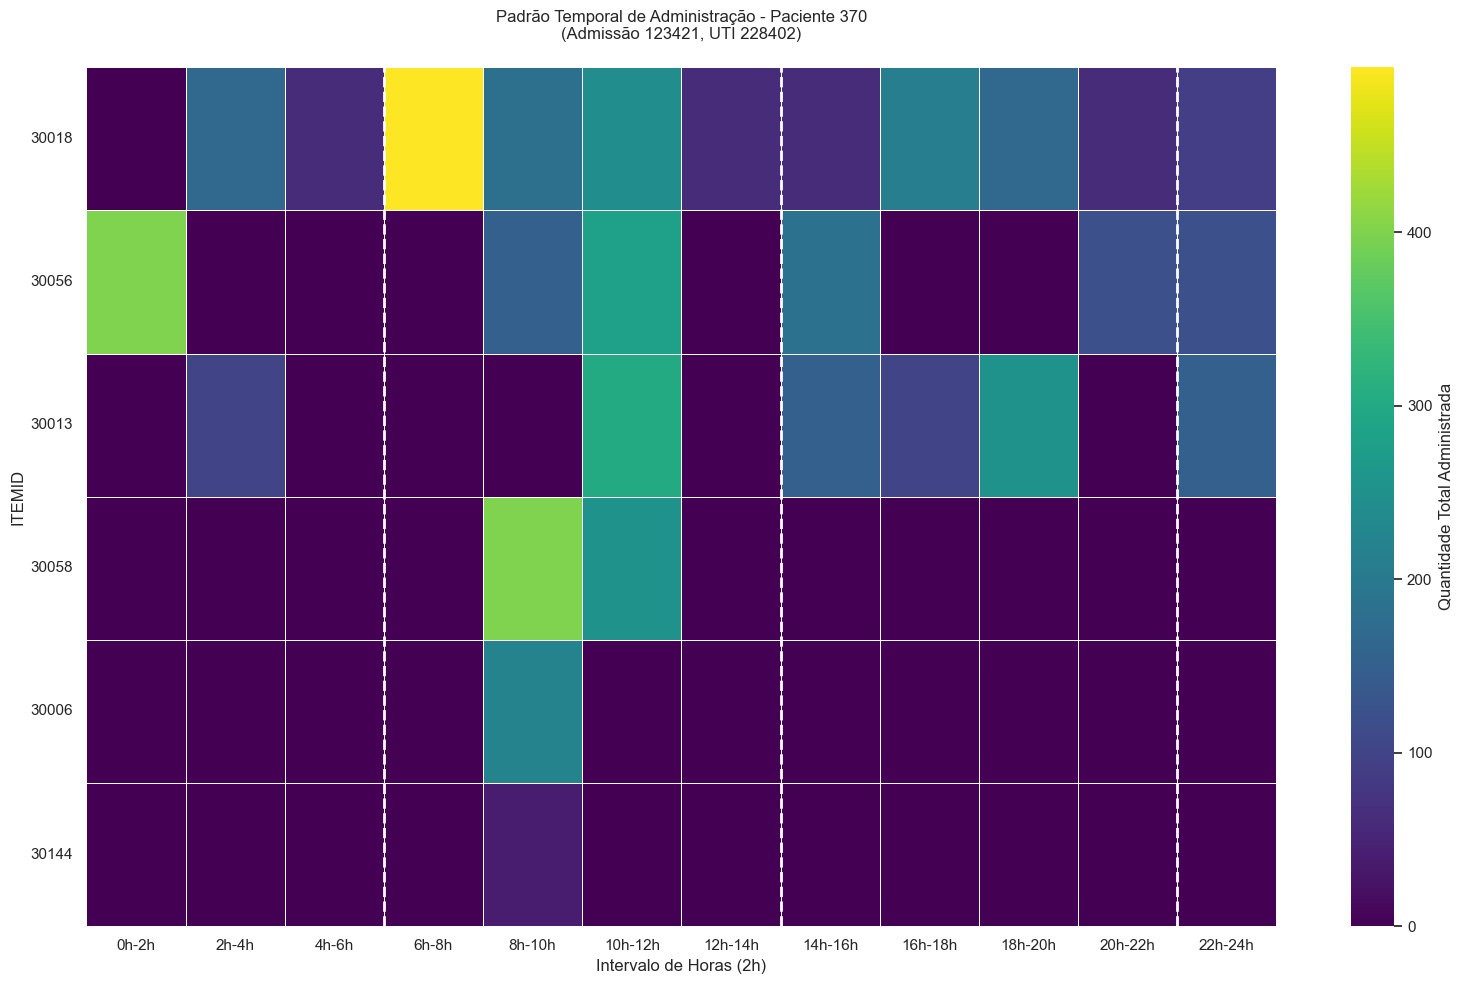


Itens administrados por turno:
shift   Manhã (0-8h)  Tarde (8-16h)  Noite (16-24h)
ITEMID                                             
30006            0.0          221.0             0.0
30013          100.0          550.0           400.0
30018          870.0          600.0           315.0
30056          150.0          465.0           240.0
30058          400.0          250.0             0.0
30144           40.0            0.0             0.0


C:\Users\rodri\AppData\Local\Temp\ipykernel_33472\2867284421.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(input_events.groupby(['ITEMID', 'shift'])['AMOUNT'].sum().unstack().fillna(0))


In [1921]:
def convert_time(df, time_col):
    df[time_col] = pd.to_datetime(df[time_col])
    df['hour'] = df[time_col].dt.hour + df[time_col].dt.minute/60
    return df

input_events = pd.concat([
    inputevents_cv[
        (inputevents_cv['SUBJECT_ID'] == subject_id) & 
        (inputevents_cv['HADM_ID'] == hadm_id) & 
        (inputevents_cv['ICUSTAY_ID'] == icustay_id)
    ],
    inputevents_mv[
        (inputevents_mv['SUBJECT_ID'] == subject_id) & 
        (inputevents_mv['HADM_ID'] == hadm_id) & 
        (inputevents_mv['ICUSTAY_ID'] == icustay_id)
    ]
])

if not input_events.empty:
    input_events = convert_time(input_events, 'CHARTTIME' if 'CHARTTIME' in input_events.columns else 'STARTTIME')
    
    input_events['hour_bin'] = (input_events['hour'] // 2) * 2
    
    heatmap_data = input_events.pivot_table(
        index='ITEMID',
        columns='hour_bin',
        values='AMOUNT',
        aggfunc='sum',
        fill_value=0
    )
    
    heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1).sort_values(ascending=False).index]
    
    hour_bins = sorted(input_events['hour_bin'].unique())
    hour_labels = [f"{int(h)}h-{int(h)+2}h" for h in hour_bins]
    
    plt.figure(figsize=(16, 10))
    sns.heatmap(
        heatmap_data,
        cmap='viridis',
        cbar_kws={'label': 'Quantidade Total Administrada'},
        linewidths=0.5,
        xticklabels=hour_labels
    )
    
    plt.title(f'Padrão Temporal de Administração - Paciente {subject_id}\n(Admissão {hadm_id}, UTI {icustay_id})', pad=20)
    plt.xlabel('Intervalo de Horas (2h)')
    plt.ylabel('ITEMID')
    plt.yticks(rotation=0)
    
    for shift in [8, 16, 24]:
        bin_position = (shift // 2) - 1
        if bin_position < len(hour_bins):
            plt.axvline(x=bin_position, color='white', linestyle='--', linewidth=2)
    
    plt.tight_layout()
    plt.show()
    
    # Estatísticas por turno
    print("\nItens administrados por turno:")
    input_events['shift'] = pd.cut(input_events['hour'], 
                                 bins=[0, 8, 16, 24], 
                                 labels=['Manhã (0-8h)', 'Tarde (8-16h)', 'Noite (16-24h)'])
    print(input_events.groupby(['ITEMID', 'shift'])['AMOUNT'].sum().unstack().fillna(0))
else:
    print("Nenhum dado de administração encontrado para este paciente.")

## Modelo (prever lenght of stay)

features:

-top 50 items usados e o top 50 menos usados (os testes mais normais, ou seja, que se fazem hora a hora, fazer media do dia) (chart_events) x

-idade/data de nascimento (tabela dos patients) x

-icd_code2 e 3 (tabela_codigos) x

-dosagem como os items têm diferentes medidas é preciso padronizar isso (chart_events)

- genero e etnia da pessoa x

In [1922]:
def is_all_numeric(df):
    ret=True
    for col in df.columns:
        col_dtype = df[col].dtype
        if not (
            np.issubdtype(col_dtype, np.number)  # catches int, float, double
            or np.issubdtype(col_dtype, np.floating)  # float, double
            or np.issubdtype(col_dtype, np.integer)   # int
        ):
            print(col)
            ret = False
    return ret

### Construir a tabela

In [1923]:
diagnoses_inf = diagnoses[(diagnoses['ICD9_CODE'] == '486') & (diagnoses['SEQ_NUM'] == 1)]
diagnoses_seq2 = diagnoses[diagnoses['SEQ_NUM'] == 2][['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']].rename(columns={'ICD9_CODE': 'ICD9_CODE_2'})
diagnoses_seq3 = diagnoses[diagnoses['SEQ_NUM'] == 3][['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']].rename(columns={'ICD9_CODE': 'ICD9_CODE_3'})

merged = diagnoses_inf.merge(diagnoses_seq2, on=['SUBJECT_ID', 'HADM_ID'], how='left')
merged = merged.merge(diagnoses_seq3, on=['SUBJECT_ID', 'HADM_ID'], how='left')
tabela = merged[['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE', 'ICD9_CODE_2', 'ICD9_CODE_3']]

hadm_ids = tabela['HADM_ID'].unique()
subject_ids = tabela['SUBJECT_ID'].unique()


tabela = icustays.merge(
    tabela,
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'
)
tabela = tabela[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ICD9_CODE', 'ICD9_CODE_2', 'ICD9_CODE_3', 'FIRST_CAREUNIT', 'LAST_CAREUNIT']] 

# Verifique o resultado
print(tabela.shape)  # Deve ser (763, n_colunas)
print(tabela.head())

(763, 8)
   SUBJECT_ID  HADM_ID  ICUSTAY_ID ICD9_CODE ICD9_CODE_2 ICD9_CODE_3  \
0         346   195392      260798       486       42731        4241   
1         111   192123      254245       486       49121        4139   
2         242   192980      270389       486         496       51889   
3         357   117876      235292       486        3453        5722   
4         368   105889      242607       486       49121       41071   

  FIRST_CAREUNIT LAST_CAREUNIT  
0           MICU          MICU  
1            CCU          MICU  
2           MICU          MICU  
3           SICU          SICU  
4           MICU          MICU  


### items

#### inputevents

In [1924]:
#top 20 item de input
cols_comuns = ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'AMOUNT', 'AMOUNTUOM']

# Combinar as duas tabelas
input_combined = pd.concat([input_cv, input_mv], ignore_index=True)

icustays = icustays[icustays['ICUSTAY_ID'].isin(tabela['ICUSTAY_ID'])].copy()
icu_ids = icustays['ICUSTAY_ID'].unique()

# Encontrar os top 20 itens mais frequentes
item_usage_counts = (
    input_combined[['ICUSTAY_ID', 'ITEMID']]
    .drop_duplicates()
    .groupby('ITEMID')
    .size()
    .sort_values(ascending=False)
)

top_20_items = item_usage_counts.head(20).index.tolist()
selected_items = top_20_items


filtered = input_combined[
    (input_combined['ITEMID'].isin(selected_items)) &
    (input_combined['ICUSTAY_ID'].isin(icu_ids))
].copy()


filtered['USED'] = 1  # Marcar como usado

pivot = (
    filtered
    .groupby(['ICUSTAY_ID', 'ITEMID'])['USED']
    .count()  
    .unstack(fill_value=0)
)

# Garantir todas as colunas 
pivot = pivot.reindex(columns=selected_items, fill_value=0)
pivot = pivot.reindex(index=icu_ids, fill_value=0)  

# Renomear colunas
pivot.columns = [f'input_item_{col}' for col in pivot.columns]
pivot = pivot.reset_index()

# 6. Juntar com informações adicionais da UTI
icustays_unique = icustays.drop_duplicates(subset=['ICUSTAY_ID'], keep='first')
pivot = pivot.merge(
    icustays_unique[['HADM_ID', 'SUBJECT_ID', 'LOS', 'ICUSTAY_ID', 'FIRST_CAREUNIT', 'LAST_CAREUNIT']],
    on='ICUSTAY_ID',
    how='left'  
)

# 7. Resultado final
print(pivot.shape)  
print(pivot.head())

(763, 26)
   ICUSTAY_ID  input_item_225158  input_item_220949  input_item_30013  \
0      260798                  0                  0                17   
1      254245                  0                  0               121   
2      270389                  0                  0                 3   
3      235292                 84                 17                 0   
4      242607                  0                  0                 6   

   input_item_226452  input_item_30018  input_item_30056  input_item_225798  \
0                  0               126                 4                  0   
1                  0               417                15                  0   
2                  0                 0                 9                  0   
3                  0                 0                 0                  4   
4                  0                54                12                  0   

   input_item_225975  input_item_226361  ...  input_item_225879  \
0        

In [1925]:
# Contar em quantas internações cada ITEMID foi usado
item_icu_counts = (
    input_combined[['ICUSTAY_ID', 'ITEMID']]
    .drop_duplicates()  
    .groupby('ITEMID')
    .size()
    .rename('count_icu')
)

# Selecionar itens raros (usados em menos de x internações)
rare_items = item_icu_counts[item_icu_counts < 6].index.tolist()


rare_usage = input_combined[
    (input_combined['ITEMID'].isin(rare_items)) &
    (input_combined['ICUSTAY_ID'].isin(icu_ids))
][['ICUSTAY_ID', 'ITEMID']].drop_duplicates()

rare_item_counts_per_icu = (
    rare_usage.groupby('ICUSTAY_ID')
    .size()
    .rename('rare_input_item_count')  
    .reset_index()
)


pivot = pivot.merge(
    rare_item_counts_per_icu,
    on='ICUSTAY_ID',
    how='left'
)

pivot['rare_input_item_count'] = pivot['rare_input_item_count'].fillna(0).astype(int)

# Verificação final
print(pivot.shape)
print(pivot.head())

(763, 27)
   ICUSTAY_ID  input_item_225158  input_item_220949  input_item_30013  \
0      260798                  0                  0                17   
1      254245                  0                  0               121   
2      270389                  0                  0                 3   
3      235292                 84                 17                 0   
4      242607                  0                  0                 6   

   input_item_226452  input_item_30018  input_item_30056  input_item_225798  \
0                  0               126                 4                  0   
1                  0               417                15                  0   
2                  0                 0                 9                  0   
3                  0                 0                 0                  4   
4                  0                54                12                  0   

   input_item_225975  input_item_226361  ...  input_item_225855  \
0        

In [1926]:
dosage_means = (
    input_combined
    .groupby(['ICUSTAY_ID', 'ITEMID'])['AMOUNT']
    .mean()
    .unstack()
)


dosage_means = dosage_means.reindex(columns=selected_items, fill_value=0)


dosage_means = dosage_means.add_prefix('MEAN_DOSE_INPUT_')
dosage_means = dosage_means.reset_index()

pivot = pivot.merge(
    dosage_means,
    on='ICUSTAY_ID',
    how='left'
)


dose_columns = [col for col in pivot.columns if col.startswith('MEAN_DOSE_INPUT_')]
pivot[dose_columns] = pivot[dose_columns].fillna(0)


if 'LOS' not in pivot.columns:
    pivot = pivot.merge(
        icustays[['ICUSTAY_ID', 'LOS']].drop_duplicates(subset='ICUSTAY_ID'),
        on='ICUSTAY_ID',
        how='left'
    )

print(pivot.shape)
pivot

(763, 47)


,ICUSTAY_ID,input_item_225158,input_item_220949,input_item_30013,input_item_226452,input_item_30018,input_item_30056,input_item_225798,input_item_225975,input_item_226361,...,MEAN_DOSE_INPUT_225851,MEAN_DOSE_INPUT_222011,MEAN_DOSE_INPUT_223262,MEAN_DOSE_INPUT_225943,MEAN_DOSE_INPUT_30144,MEAN_DOSE_INPUT_225879,MEAN_DOSE_INPUT_225855,MEAN_DOSE_INPUT_225799,MEAN_DOSE_INPUT_30054,MEAN_DOSE_INPUT_225154
0,260798,0,0,17,0,126,4,0,0,0,...,0.0,0.000000,0.0,0.000000,57.500000,0.0,0.0,0.000000,0.0,0.000000
1,254245,0,0,121,0,417,15,0,0,0,...,0.0,0.000000,0.0,0.000000,68.461538,0.0,0.0,0.000000,0.0,0.000000
2,270389,0,0,3,0,0,9,0,0,0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
3,235292,84,17,0,0,0,0,4,29,0,...,0.0,2.000000,0.0,7.089637,0.000000,0.0,0.0,63.866667,0.0,0.000000
4,242607,0,0,6,0,54,12,0,0,0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,3350.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,212639,21,29,0,6,0,0,0,7,1,...,1.0,2.000000,0.0,39.832167,0.000000,1.0,1.0,52.500000,0.0,4.000000
759,297547,10,17,0,0,0,0,6,1,0,...,0.0,0.000000,0.0,10.000000,0.000000,0.0,1.0,0.000000,0.0,5.473265
760,275520,2,2,0,7,0,0,0,1,1,...,1.0,0.000000,4.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
761,213932,4,6,0,7,0,0,2,0,0,...,1.0,2.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000


In [1927]:
from sklearn.preprocessing import MinMaxScaler

dose_columns = [col for col in pivot.columns if isinstance(col, str) and col.startswith('MEAN_DOSE_')]


scaler = MinMaxScaler()
pivot_scaled = pivot.copy()
pivot_scaled[dose_columns] = scaler.fit_transform(pivot[dose_columns])

pivot=pivot_scaled.copy()

In [1928]:
def transform_selected_items(pivot, d_items, selected_items):
    item_to_category = (
        d_items[d_items['ITEMID'].isin(selected_items)]
        .set_index('ITEMID')['CATEGORY']
        .astype(str)
        .to_dict()
    )
    
    # Adicionar 'Unknown' para itens não mapeados
    for item in selected_items:
        if item not in item_to_category:
            item_to_category[item] = 'Unknown'
            print(f"Aviso: Item {item} não encontrado em d_items - mapeado como 'Unknown'")
    
    categories = sorted(set(item_to_category.values()), key=str)
    
    # Inicializar DataFrames para resultados
    total_df = pd.DataFrame(0, index=pivot.index, columns=[f'TOTAL_{c}' for c in categories])
    dose_sum_df = pd.DataFrame(0, index=pivot.index, columns=[f'DOSE_SUM_{c}' for c in categories])
    count_df = pd.DataFrame(0, index=pivot.index, columns=[f'COUNT_{c}' for c in categories])
    
    for item in selected_items:
        category = item_to_category[item]
        
        # Processar input (se existir a coluna)
        input_col = f'input_item_{item}'
        if input_col in pivot.columns:
            total_df[f'TOTAL_{category}'] += pivot[input_col]
            count_df[f'COUNT_{category}'] += (pivot[input_col] > 0).astype(int)
        
        # Processar dose (se existir a coluna)
        dose_col = f'MEAN_DOSE_INPUT_{item}'
        if dose_col in pivot.columns:
            mask = pivot[dose_col] > 0
            dose_sum_df[f'DOSE_SUM_{category}'] += pivot[dose_col].where(mask, 0)
    
    # Calcular médias de dose
    avg_dose_df = pd.DataFrame(index=pivot.index)
    for category in categories:
        count_col = f'COUNT_{category}'
        dose_sum_col = f'DOSE_SUM_{category}'
        
        avg_dose_df[f'AVG_DOSE_{category}'] = np.where(
            count_df[count_col] > 0,
            dose_sum_df[dose_sum_col] / count_df[count_col],
            0
        )
    
    cols_to_keep = [col for col in pivot.columns 
                   if not (col.startswith('input_item_') and int(col.split('_')[-1]) in selected_items) and
                   not (col.startswith('MEAN_DOSE_INPUT_') and int(col.split('_')[-1]) in selected_items)]
    
    new_pivot = pd.concat([
        pivot[cols_to_keep],
        total_df,
        avg_dose_df
    ], axis=1)
    
    for category in categories:
        total_col = f'TOTAL_{category}'
        dose_col = f'AVG_DOSE_{category}'
        new_pivot[dose_col] = new_pivot[dose_col].where(new_pivot[total_col] > 0, 0)
    
    return new_pivot

pivot = transform_selected_items(pivot, d_items, selected_items)


print(pivot.shape)
pivot

(763, 15)


,ICUSTAY_ID,HADM_ID,SUBJECT_ID,LOS,FIRST_CAREUNIT,LAST_CAREUNIT,rare_input_item_count,TOTAL_Antibiotics,TOTAL_Fluids/Intake,TOTAL_Medications,TOTAL_nan,AVG_DOSE_Antibiotics,AVG_DOSE_Fluids/Intake,AVG_DOSE_Medications,AVG_DOSE_nan
0,260798,195392,346,4.854479,MICU,MICU,0,0,0,0,152,0.000000,0.000000,0.000000,0.198173
1,254245,192123,111,10.570833,CCU,MICU,2,0,0,0,579,0.000000,0.000000,0.000000,0.089284
2,270389,192980,242,1.701389,MICU,MICU,0,0,0,0,12,0.000000,0.000000,0.000000,0.193333
3,235292,117876,357,14.064063,SICU,SICU,3,4,163,58,0,0.001000,0.180930,0.513059,0.000000
4,242607,105889,368,4.906979,MICU,MICU,0,0,0,0,73,0.000000,0.000000,0.000000,0.234090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,212639,121321,97399,5.687755,MICU,MICU,2,9,78,16,0,0.467111,0.278167,0.389048,0.000000
759,297547,106929,91867,2.886759,MICU,MICU,0,8,29,22,0,0.450500,0.152046,0.554733,0.000000
760,275520,150608,99185,1.141921,MICU,MICU,0,1,12,2,0,0.500000,0.150489,0.608108,0.000000
761,213932,107472,90688,2.348021,MICU,MICU,0,3,17,1,0,0.250500,0.260244,0.142857,0.000000


#### labevents

In [1929]:
all_hadm_ids = icustays['HADM_ID'].unique()  

# Obter os top 10 itens
top_10_labitems = (
    labevents[['HADM_ID', 'ITEMID']]
    .drop_duplicates()
    .groupby('ITEMID')
    .size()
    .sort_values(ascending=False)
    .head(10)
    .index.tolist()
)

lab_pivot = (
    labevents[labevents['ITEMID'].isin(top_10_labitems)]
    .groupby(['HADM_ID', 'ITEMID'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=top_10_labitems, fill_value=0) 
    .reindex(index=all_hadm_ids, fill_value=0)        
)

lab_pivot.columns = [f'lab_item_{item}' for item in lab_pivot.columns]
lab_pivot = lab_pivot.reset_index()

print(lab_pivot.shape)
print(lab_pivot.head())

(725, 11)
   HADM_ID  lab_item_50912  lab_item_50931  lab_item_50902  lab_item_50882  \
0   195392               6               6               6               6   
1   192123              15              15              15              15   
2   192980               4               4               4               4   
3   117876              38              39              38              37   
4   105889               7               7               7               7   

   lab_item_50983  lab_item_50971  lab_item_50868  lab_item_51006  \
0               6               7               6               6   
1              15              16              15              15   
2               4               4               4               4   
3              38              38              37              38   
4               7               8               7               7   

   lab_item_51277  lab_item_51279  
0               6               6  
1              11              11 

In [1930]:
item_hadm_counts = (
    labevents[['HADM_ID', 'ITEMID']]
    .drop_duplicates()  
    .groupby('ITEMID')
    .size()
    .rename('count_hadm')
)

rare_labitems = item_hadm_counts[item_hadm_counts < 6].index.tolist()

# Contar quantos testes raros cada HADM_ID teve
rare_lab_usage = (
    labevents[
        (labevents['ITEMID'].isin(rare_labitems)) &
        (labevents['HADM_ID'].isin(lab_pivot['HADM_ID']))
    ][['HADM_ID', 'ITEMID']]
    .drop_duplicates()
    .groupby('HADM_ID')
    .size()
    .rename('rare_labitem_count')
    .reset_index()
)

lab_pivot = lab_pivot.merge(
    rare_lab_usage,
    on='HADM_ID',
    how='left'
)

lab_pivot['rare_labitem_count'] = lab_pivot['rare_labitem_count'].fillna(0).astype(int)

cols_to_keep = ['HADM_ID'] + [col for col in lab_pivot.columns if col.startswith('lab_item_')] + ['rare_labitem_count']
lab_pivot = lab_pivot[cols_to_keep]


print(lab_pivot.shape)
print(lab_pivot.head())

(725, 12)
   HADM_ID  lab_item_50912  lab_item_50931  lab_item_50902  lab_item_50882  \
0   195392               6               6               6               6   
1   192123              15              15              15              15   
2   192980               4               4               4               4   
3   117876              38              39              38              37   
4   105889               7               7               7               7   

   lab_item_50983  lab_item_50971  lab_item_50868  lab_item_51006  \
0               6               7               6               6   
1              15              16              15              15   
2               4               4               4               4   
3              38              38              37              38   
4               7               8               7               7   

   lab_item_51277  lab_item_51279  rare_labitem_count  
0               6               6                 

In [1931]:
labvalue_means = (
    labevents[labevents['ITEMID'].isin(top_10_labitems)]  # Filtra apenas os top 10 itens
    .groupby(['HADM_ID', 'ITEMID'])['VALUENUM']  # Agrupa por hospitalização e item
    .mean()  # Calcula a média dos valores
    .unstack()  # Transforma ITEMID em colunas
    .reindex(columns=top_10_labitems, fill_value=0)  
    .reindex(index=all_hadm_ids, fill_value=0)  
)

labvalue_means = labvalue_means.add_prefix('MEAN_LAB_VALUE_')
labvalue_means = labvalue_means.reset_index()

lab_pivot = lab_pivot.merge(
    labvalue_means,
    on='HADM_ID',
    how='left'
)

value_columns = [col for col in lab_pivot.columns if col.startswith('MEAN_LAB_VALUE_')]
lab_pivot[value_columns] = lab_pivot[value_columns].fillna(0)

print(lab_pivot.shape)
lab_pivot

(725, 22)


,HADM_ID,lab_item_50912,lab_item_50931,lab_item_50902,lab_item_50882,lab_item_50983,lab_item_50971,lab_item_50868,lab_item_51006,lab_item_51277,...,MEAN_LAB_VALUE_50912,MEAN_LAB_VALUE_50931,MEAN_LAB_VALUE_50902,MEAN_LAB_VALUE_50882,MEAN_LAB_VALUE_50983,MEAN_LAB_VALUE_50971,MEAN_LAB_VALUE_50868,MEAN_LAB_VALUE_51006,MEAN_LAB_VALUE_51277,MEAN_LAB_VALUE_51279
0,195392,6,6,6,6,6,7,6,6,6,...,0.933333,117.833333,102.833333,30.000000,140.166667,4.114286,11.666667,20.666667,22.266667,3.066667
1,192123,15,15,15,15,15,16,15,15,11,...,0.593333,152.200000,103.400000,30.000000,141.466667,3.831250,11.866667,20.333333,12.454545,4.204545
2,192980,4,4,4,4,4,4,4,4,4,...,0.775000,92.750000,100.750000,30.500000,141.500000,3.925000,14.000000,19.000000,14.150000,4.217500
3,117876,38,39,38,37,38,38,37,38,29,...,0.844737,163.538462,105.473684,31.216216,141.210526,3.868421,8.378378,17.500000,14.944828,2.932414
4,105889,7,7,7,7,7,8,7,7,6,...,1.214286,142.714286,105.285714,23.714286,138.714286,4.500000,14.285714,24.285714,15.133333,4.286667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,121321,10,10,10,10,10,10,10,10,9,...,1.330000,113.000000,102.900000,27.400000,138.900000,4.090000,12.800000,17.300000,12.866667,3.304444
721,106929,1,1,1,1,1,1,1,1,1,...,0.800000,88.000000,102.000000,28.000000,136.000000,5.200000,11.000000,18.000000,14.500000,3.810000
722,150608,5,5,5,5,5,5,5,5,5,...,1.780000,136.200000,99.200000,32.400000,140.200000,4.380000,13.000000,43.200000,18.700000,2.906000
723,107472,5,5,5,5,5,5,5,5,5,...,1.800000,91.200000,102.400000,25.000000,137.000000,4.140000,13.800000,31.400000,15.300000,3.132000


In [1932]:
dose_columns = [col for col in lab_pivot.columns if isinstance(col, str) and col.startswith('MEAN_LAB_VALUE')]


scaler = MinMaxScaler()
lab_pivot_scaled = lab_pivot.copy()
lab_pivot_scaled[dose_columns] = scaler.fit_transform(lab_pivot[dose_columns])

lab_pivot=lab_pivot_scaled.copy()

In [1933]:
def transform_selected_labitems(lab_pivot, d_labitems, selected_labitems):
    item_to_category = (
        d_labitems[d_labitems['ITEMID'].isin(selected_labitems)]
        .set_index('ITEMID')['CATEGORY']
        .astype(str)
        .to_dict()
    )
    
    for item in selected_labitems:
        if item not in item_to_category:
            item_to_category[item] = 'Unknown'
            print(f"Aviso: Item {item} não encontrado em d_labitems - mapeado como 'Unknown'")
    
    categories = sorted(set(item_to_category.values()), key=str)
    
    total_df = pd.DataFrame(0, index=lab_pivot.index, columns=[f'TOTAL_LAB_{c}' for c in categories])
    value_sum_df = pd.DataFrame(0, index=lab_pivot.index, columns=[f'VALUE_SUM_{c}' for c in categories])
    count_df = pd.DataFrame(0, index=lab_pivot.index, columns=[f'COUNT_LAB_{c}' for c in categories])
    
    # Processar apenas os selected_labitems
    for item in selected_labitems:
        category = item_to_category[item]
        
        # Processar teste (se existir a coluna)
        test_col = f'lab_item_{item}'
        if test_col in lab_pivot.columns:
            total_df[f'TOTAL_LAB_{category}'] += lab_pivot[test_col]
            count_df[f'COUNT_LAB_{category}'] += (lab_pivot[test_col] > 0).astype(int)
        
        # Processar valor (se existir a coluna)
        value_col = f'MEAN_LAB_VALUE_{item}'
        if value_col in lab_pivot.columns:
            mask = lab_pivot[value_col] > 0
            value_sum_df[f'VALUE_SUM_{category}'] += lab_pivot[value_col].where(mask, 0)
    
    # Calcular médias de valor
    avg_value_df = pd.DataFrame(index=lab_pivot.index)
    for category in categories:
        count_col = f'COUNT_LAB_{category}'
        value_sum_col = f'VALUE_SUM_{category}'
        
        avg_value_df[f'AVG_LAB_VALUE_{category}'] = np.where(
            count_df[count_col] > 0,
            value_sum_df[value_sum_col] / count_df[count_col],
            0
        )
    
    cols_to_keep = [col for col in lab_pivot.columns 
                   if not (col.startswith('lab_item_') and int(col.split('_')[-1]) in selected_labitems) and
                   not (col.startswith('MEAN_LAB_VALUE_') and int(col.split('_')[-1]) in selected_labitems)]
    
    new_lab_pivot = pd.concat([
        lab_pivot[cols_to_keep],
        total_df,
        avg_value_df
    ], axis=1)

    for category in categories:
        total_col = f'TOTAL_LAB_{category}'
        value_col = f'AVG_LAB_VALUE_{category}'
        new_lab_pivot[value_col] = new_lab_pivot[value_col].where(new_lab_pivot[total_col] > 0, 0)
    
    return new_lab_pivot

# Aplicar a função
lab_pivot = transform_selected_labitems(lab_pivot, labitems, top_10_labitems)

print(lab_pivot.shape)
lab_pivot.head()

(725, 6)


,HADM_ID,rare_labitem_count,TOTAL_LAB_Chemistry,TOTAL_LAB_Hematology,AVG_LAB_VALUE_Chemistry,AVG_LAB_VALUE_Hematology
0,195392,0,49,12,0.485021,0.653815
1,192123,0,121,22,0.488423,0.570458
2,192980,0,32,8,0.484964,0.602100
3,117876,0,303,58,0.478235,0.510728
4,105889,0,57,12,0.500947,0.625523


In [1934]:
#juntar lab_pivot à pivot

final_pivot = pivot.merge(
    lab_pivot,
    on='HADM_ID',
    how='left'  # Mantém todos os registros da tabela pivot
)

# Preencher valores NA (caso algum HADM_ID não tenha dados de laboratório)
cols_to_fill = [col for col in lab_pivot.columns if col != 'HADM_ID']
final_pivot[cols_to_fill] = final_pivot[cols_to_fill].fillna(0)

pivot = final_pivot.copy()

for col in sorted(pivot.columns):
    print(f"- {col}")

# Mostrar shape final
print(pivot.shape)

- AVG_DOSE_Antibiotics
- AVG_DOSE_Fluids/Intake
- AVG_DOSE_Medications
- AVG_DOSE_nan
- AVG_LAB_VALUE_Chemistry
- AVG_LAB_VALUE_Hematology
- FIRST_CAREUNIT
- HADM_ID
- ICUSTAY_ID
- LAST_CAREUNIT
- LOS
- SUBJECT_ID
- TOTAL_Antibiotics
- TOTAL_Fluids/Intake
- TOTAL_LAB_Chemistry
- TOTAL_LAB_Hematology
- TOTAL_Medications
- TOTAL_nan
- rare_input_item_count
- rare_labitem_count
(763, 20)


nesta parte de trabalhar com as features, tivemos contratempos causados pelos dados e o que eles dão, como:

- chartevents nao tem todos os casos, entao tivemos de trabalhar com as tabelas lab_events e inputevents
- labevents nao tem a icustays, entao trabalhamos com o hadm_id, mas que tem um menor numero de casos que o icustay_id, entao ha repetiçoes
- grande parte dos items dos inputevents nao têm dados no D_ITEMS, entao ficamos com muitos items no nan, mas nao havia muito mais a fazer

### outras categorias

In [1935]:
#ICD9_CODES
pivot = pivot.merge(
    tabela[['ICUSTAY_ID', 'ICD9_CODE_2', 'ICD9_CODE_3']],
    on='ICUSTAY_ID',
    how='left'  
)

print(pivot.shape) 
print(pivot.head())

(763, 22)
   ICUSTAY_ID  HADM_ID  SUBJECT_ID        LOS FIRST_CAREUNIT LAST_CAREUNIT  \
0      260798   195392         346   4.854479           MICU          MICU   
1      254245   192123         111  10.570833            CCU          MICU   
2      270389   192980         242   1.701389           MICU          MICU   
3      235292   117876         357  14.064063           SICU          SICU   
4      242607   105889         368   4.906979           MICU          MICU   

   rare_input_item_count  TOTAL_Antibiotics  TOTAL_Fluids/Intake  \
0                      0                  0                    0   
1                      2                  0                    0   
2                      0                  0                    0   
3                      3                  4                  163   
4                      0                  0                    0   

   TOTAL_Medications  ...  AVG_DOSE_Fluids/Intake  AVG_DOSE_Medications  \
0                  0  ...            

In [1936]:
#age
intime_unique = icustays[['ICUSTAY_ID', 'INTIME']].drop_duplicates(subset='ICUSTAY_ID')
dob_unique = patients[['SUBJECT_ID', 'DOB']].drop_duplicates(subset='SUBJECT_ID')

# Merge INTIME com pivot (com base no HADM_ID)
pivot = pivot.merge(intime_unique, on='ICUSTAY_ID', how='left')

# Merge DOB com pivot (com base no SUBJECT_ID)
pivot = pivot.merge(dob_unique, on='SUBJECT_ID', how='left')

# Converter para datetime, tratando erros
pivot['DOB'] = pd.to_datetime(pivot['DOB'], errors='coerce')
pivot['INTIME'] = pd.to_datetime(pivot['INTIME'], errors='coerce')

# Calcular idade com base apenas no ano
pivot['AGE'] = pivot['INTIME'].dt.year - pivot['DOB'].dt.year

# Remover colunas temporárias (opcional)
pivot = pivot.drop(columns=['DOB', 'INTIME'])

In [1937]:
#a idade máxima é 89, entao valores acima de tal é para passar para 89

pivot.loc[pivot['AGE'] > 89, 'AGE'] = 89

In [1938]:
admissions_selected = admissions[['HADM_ID', 'ADMISSION_LOCATION', 'RELIGION', 
                                  'MARITAL_STATUS', 'ETHNICITY', 'INSURANCE']]

# Fazer o merge com a tabela pivot usando HADM_ID
pivot = pivot.merge(admissions_selected, on='HADM_ID', how='left')

# Visualizar o resultado
print(pivot.shape)
print(pivot.head())

(763, 28)
   ICUSTAY_ID  HADM_ID  SUBJECT_ID        LOS FIRST_CAREUNIT LAST_CAREUNIT  \
0      260798   195392         346   4.854479           MICU          MICU   
1      254245   192123         111  10.570833            CCU          MICU   
2      270389   192980         242   1.701389           MICU          MICU   
3      235292   117876         357  14.064063           SICU          SICU   
4      242607   105889         368   4.906979           MICU          MICU   

   rare_input_item_count  TOTAL_Antibiotics  TOTAL_Fluids/Intake  \
0                      0                  0                    0   
1                      2                  0                    0   
2                      0                  0                    0   
3                      3                  4                  163   
4                      0                  0                    0   

   TOTAL_Medications  ...  AVG_LAB_VALUE_Chemistry  AVG_LAB_VALUE_Hematology  \
0                  0  ...       

ATE AQUI ESTA TUDO IGUAL

tratar de missing values, one-hot enconding e selecionar apenas as variaveis significativas

In [1939]:
missing_summary = pivot.isna().sum()
missing_summary = missing_summary[missing_summary > 0]  # Mostrar apenas colunas com pelo menos um NaN

print("Colunas com valores ausentes:")
print(missing_summary.sort_values(ascending=False))

Colunas com valores ausentes:
MARITAL_STATUS    21
RELIGION           4
dtype: int64


Por todas as entradas a valores numericos

In [1940]:
# (Re)criar colunas para ICD9
def icd9_to_chapter(code):
    # Convert to string and clean
    code_str = str(code).strip()
    
    # Handle V codes (supplementary classification)
    if code_str.startswith('V'):
        return 'Supplemental'
    
    # Handle E codes (external causes of injury)
    if code_str.startswith('E'):
        return 'External_Injury'
    
    # Extract first 3 digits for numeric codes
    try:
        # Handle codes like '4280' (convert to 428) or '486' (stays 486)
        numeric_part = code_str.split('.')[0] if '.' in code_str else code_str
        code_num = float(numeric_part[:3])
    except:
        return 'Unknown'
    
    # Map to chapters
    if 1 <= code_num <= 139: return 'Infectious'
    elif 140 <= code_num <= 239: return 'Neoplasms'
    elif 240 <= code_num <= 279: return 'Endocrine'
    elif 280 <= code_num <= 289: return 'Blood'
    elif 290 <= code_num <= 319: return 'Mental'
    elif 320 <= code_num <= 389: return 'Nervous'
    elif 390 <= code_num <= 459: return 'Circulatory'
    elif 460 <= code_num <= 519: return 'Respiratory'
    elif 520 <= code_num <= 579: return 'Digestive'
    elif 580 <= code_num <= 629: return 'Genitourinary'
    elif 630 <= code_num <= 679: return 'Pregnancy'
    elif 680 <= code_num <= 709: return 'Skin'
    elif 710 <= code_num <= 739: return 'Musculoskeletal'
    elif 740 <= code_num <= 759: return 'Congenital'
    elif 760 <= code_num <= 779: return 'Perinatal'
    elif 780 <= code_num <= 799: return 'Ill-defined'
    elif 800 <= code_num <= 999: return 'Injury'
    else: return 'Other'

pivot['ICD9_CHAPTER_2'] = pivot['ICD9_CODE_2'].apply(icd9_to_chapter)
pivot['ICD9_CHAPTER_3'] = pivot['ICD9_CODE_3'].apply(icd9_to_chapter)

# Mostrar forma final
print("Número final de colunas:", pivot.shape[1])

Número final de colunas: 30


In [1941]:
# Columns to process
cat_cols = ['RELIGION', 'ETHNICITY', 'MARITAL_STATUS','ADMISSION_LOCATION', 'INSURANCE', 
            'ICD9_CHAPTER_2', 'ICD9_CHAPTER_3', 'FIRST_CAREUNIT', 'LAST_CAREUNIT'] 

# Step 1: Group rare categories into 'Other'
threshold = 8  # Adjust threshold as needed
for col in cat_cols:
    freq = pivot[col].value_counts()
    rare = freq[freq < threshold].index
    pivot[col] = pivot[col].apply(lambda x: 'Other' if x in rare else x)

# Step 2: Ordinal encode (top 8 -> 1-8, rest/Other -> 0)
for col in cat_cols:
    top_categories = pivot[col].value_counts().index.tolist()
    pivot[col] = pivot[col].apply(
        lambda x: top_categories.index(x) + 1 if x in top_categories else 0
    )

# Check results
print(pivot.head())

   ICUSTAY_ID  HADM_ID  SUBJECT_ID        LOS  FIRST_CAREUNIT  LAST_CAREUNIT  \
0      260798   195392         346   4.854479               1              1   
1      254245   192123         111  10.570833               2              1   
2      270389   192980         242   1.701389               1              1   
3      235292   117876         357  14.064063               3              3   
4      242607   105889         368   4.906979               1              1   

   rare_input_item_count  TOTAL_Antibiotics  TOTAL_Fluids/Intake  \
0                      0                  0                    0   
1                      2                  0                    0   
2                      0                  0                    0   
3                      3                  4                  163   
4                      0                  0                    0   

   TOTAL_Medications  ...  ICD9_CODE_2  ICD9_CODE_3  AGE  ADMISSION_LOCATION  \
0                  0  ...     

testar modelos, no caso, RFregressor e Lasso e kneighbors regressor(aqui é melhor reduzir ainda mais o numero de colunas)

talvez ver um modelo de classes tambem, dividindo o tempo em 3 classes e prevendo em que espaço de tempo(classe) o paciente fica

-ter em atençao tirar as colunas HADM_ID e SUBJECT_ID

-definir bem a janela da LOS

com isto perceber quais as colunas mais importantes e testar de novo

enfiar esta merda no relatorio:
High Cardinality Features:

    If a categorical variable has many unique values (e.g., "City" with 100+ categories), one-hot encoding will create a large number of binary columns.

    This increases the dimensionality of the dataset, which can cause the model to memorize noise (overfit) rather than generalize, especially with limited data.

### modelos

In [1942]:
pivot.drop(['HADM_ID', 'SUBJECT_ID', 'ICD9_CODE_3', 'ICD9_CODE_2', 'ICUSTAY_ID'], inplace=True, axis=1)
pivot['LOS'] = np.clip(pivot['LOS'], 0.1, 15)
pivot
print(pivot.shape)
pivot

(763, 25)


,LOS,FIRST_CAREUNIT,LAST_CAREUNIT,rare_input_item_count,TOTAL_Antibiotics,TOTAL_Fluids/Intake,TOTAL_Medications,TOTAL_nan,AVG_DOSE_Antibiotics,AVG_DOSE_Fluids/Intake,...,AVG_LAB_VALUE_Chemistry,AVG_LAB_VALUE_Hematology,AGE,ADMISSION_LOCATION,RELIGION,MARITAL_STATUS,ETHNICITY,INSURANCE,ICD9_CHAPTER_2,ICD9_CHAPTER_3
0,4.854479,1,1,0,0,0,0,152,0.000000,0.000000,...,0.485021,0.653815,85,1,1,3,2,1,2,1
1,10.570833,2,1,2,0,0,0,579,0.000000,0.000000,...,0.488423,0.570458,67,1,3,1,1,1,1,1
2,1.701389,1,1,0,0,0,0,12,0.000000,0.000000,...,0.484964,0.602100,77,3,1,3,4,1,1,2
3,14.064063,3,3,3,4,163,58,0,0.001000,0.180930,...,0.478235,0.510728,64,1,2,1,1,2,5,8
4,4.906979,1,1,0,0,0,0,73,0.000000,0.000000,...,0.500947,0.625523,89,1,2,3,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,5.687755,1,1,2,9,78,16,0,0.467111,0.278167,...,0.480612,0.503852,51,2,2,1,7,2,2,3
759,2.886759,1,1,0,8,29,22,0,0.450500,0.152046,...,0.479182,0.574893,80,1,2,1,1,1,1,5
760,1.141921,1,1,0,1,12,2,0,0.500000,0.150489,...,0.533522,0.576277,77,1,2,1,1,1,3,2
761,2.348021,1,1,0,3,17,1,0,0.250500,0.260244,...,0.490742,0.533551,84,1,1,3,1,1,3,9


In [1943]:
pivot.to_csv('C:/Users/rodri/Downloads/pivot.csv', index=False)

In [1944]:
X = pivot.drop('LOS', axis=1)  # Replace with your actual target column
y = pivot['LOS']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [1945]:
models = {
    # Linear Models
    "Linear Regression": LinearRegression(),
    "Ridge (L2)": Ridge(alpha=1.0),
    "Lasso (L1)": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    
    # Tree-Based
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    
    # Boosting Algorithms
    "AdaBoost": AdaBoostRegressor(n_estimators=50, random_state=42),
    
    # Other
    "k-NN": KNeighborsRegressor(n_neighbors=5),
    "Support Vector (SVR)": SVR(kernel='rbf', C=1.0),
    "Neural Network (MLP)": MLPRegressor(hidden_layer_sizes=(50,), max_iter=500, random_state=42)
}

In [1946]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
for name, model in models.items():
    model = model.fit(X_train, y_train)
    preds = model.predict(X_test)
    model.fit(X_train, y_train)

    print(f"\n{name} results:")
    print(f"R² Score: {r2_score(y_test, preds):.4f}")
    print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, preds):.4f}")
    print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, preds)):.4f}")
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, preds):.4f}")
    


Linear Regression results:
R² Score: 0.7093
Mean Squared Error (MSE): 4.2462
Root Mean Squared Error (RMSE): 2.0606
Mean Absolute Error (MAE): 1.4247

Ridge (L2) results:
R² Score: 0.7111
Mean Squared Error (MSE): 4.2197
Root Mean Squared Error (RMSE): 2.0542
Mean Absolute Error (MAE): 1.4235

Lasso (L1) results:
R² Score: 0.7197
Mean Squared Error (MSE): 4.0936
Root Mean Squared Error (RMSE): 2.0233
Mean Absolute Error (MAE): 1.3715

ElasticNet results:
R² Score: 0.7212
Mean Squared Error (MSE): 4.0725
Root Mean Squared Error (RMSE): 2.0180
Mean Absolute Error (MAE): 1.3579

Decision Tree results:
R² Score: 0.7995
Mean Squared Error (MSE): 2.9285
Root Mean Squared Error (RMSE): 1.7113
Mean Absolute Error (MAE): 1.1515

Random Forest results:
R² Score: 0.8607
Mean Squared Error (MSE): 2.0339
Root Mean Squared Error (RMSE): 1.4261
Mean Absolute Error (MAE): 0.9945

Gradient Boosting results:
R² Score: 0.8463
Mean Squared Error (MSE): 2.2455
Root Mean Squared Error (RMSE): 1.4985
Mean A

RF

In [1947]:
from sklearn.feature_selection import f_regression

f_vals, p_vals = f_regression(X_train, y_train)
anova_results = pd.Series(p_vals, index=X_train.columns)
selected_features = anova_results[anova_results < 0.05].index.tolist()

#pelo grafico de correlaçao, achamos por bem acrescentar a coluna age e a ICD9_CHAPTER_3

extra_features = ['AGE', 'ICD9_CHAPTER_3']
for feat in extra_features:
    if feat in X_train.columns and feat not in selected_features:
        selected_features.append(feat)

print(selected_features)
print(len(selected_features))

['FIRST_CAREUNIT', 'rare_input_item_count', 'TOTAL_Antibiotics', 'TOTAL_Fluids/Intake', 'TOTAL_Medications', 'TOTAL_nan', 'AVG_DOSE_Fluids/Intake', 'rare_labitem_count', 'TOTAL_LAB_Chemistry', 'TOTAL_LAB_Hematology', 'AVG_LAB_VALUE_Hematology', 'ICD9_CHAPTER_2', 'AGE', 'ICD9_CHAPTER_3']
14


In [1948]:
#Random Forest Grid-Search
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 10],
    'n_estimators': [50, 100],
}
grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Melhores parâmetros:", grid.best_params_)

# Filtrar os dados com as features selecionadas
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Criar e treinar o modelo com os melhores parâmetros do GridSearch
best_params = grid.best_params_
rf_model = RandomForestRegressor(**best_params, random_state=42)
rf_model.fit(X_train_selected, y_train)

# Fazer previsões
preds = rf_model.predict(X_test_selected)

# Avaliar o modelo
print("\nRandom Forest com features selecionadas e tuning:")
print(f"R² Score: {r2_score(y_test, preds):.4f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, preds):.4f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, preds)):.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, preds):.4f}")

Melhores parâmetros: {'max_depth': 10, 'n_estimators': 100}

Random Forest com features selecionadas e tuning:
R² Score: 0.8505
Mean Squared Error (MSE): 2.1836
Root Mean Squared Error (RMSE): 1.4777
Mean Absolute Error (MAE): 1.0359


Gradient boost

In [1949]:
#Gradient Boost Grid-Search

param_grid_gb = {
    'max_depth': [3, 5, 10],
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1, 0.2]  # opcional: para afinar mais
}


grid_gb = GridSearchCV(GradientBoostingRegressor(), param_grid_gb, cv=5)
grid_gb.fit(X_train_selected, y_train)
print("Melhores parâmetros (Gradient Boosting):", grid_gb.best_params_)

best_params_gb = grid_gb.best_params_
gb_model = GradientBoostingRegressor(**best_params_gb, random_state=42)
gb_model.fit(X_train_selected, y_train)

gb_preds = gb_model.predict(X_test_selected)

print("\nGradient Boosting com features selecionadas e tuning:")
print(f"R² Score: {r2_score(y_test, gb_preds):.4f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, gb_preds):.4f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, gb_preds)):.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, gb_preds):.4f}")

Melhores parâmetros (Gradient Boosting): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}

Gradient Boosting com features selecionadas e tuning:
R² Score: 0.8487
Mean Squared Error (MSE): 2.2097
Root Mean Squared Error (RMSE): 1.4865
Mean Absolute Error (MAE): 1.0544


NN

In [1950]:
param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],  # termo de regularização L2
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [500, 1000]
}

# Normalização dos dados para redes neurais
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

grid_nn = GridSearchCV(MLPRegressor(random_state=42), 
                      param_grid_nn, 
                      cv=5,
                      n_jobs=-1,  # usar todos os cores disponíveis
                      verbose=1)  # mostrar progresso

grid_nn.fit(X_train_scaled, y_train)
print("\nMelhores parâmetros (Neural Network):", grid_nn.best_params_)

# Treinar modelo final com melhores parâmetros
best_params_nn = grid_nn.best_params_
nn_model = MLPRegressor(**best_params_nn, random_state=42)
nn_model.fit(X_train_scaled, y_train)

# Previsões e métricas
nn_preds = nn_model.predict(X_test_scaled)

print("\nNeural Network com features selecionadas e tuning:")
print(f"R² Score: {r2_score(y_test, nn_preds):.4f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, nn_preds):.4f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, nn_preds)):.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, nn_preds):.4f}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits

Melhores parâmetros (Neural Network): {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'max_iter': 500}

Neural Network com features selecionadas e tuning:
R² Score: 0.8602
Mean Squared Error (MSE): 2.0423
Root Mean Squared Error (RMSE): 1.4291
Mean Absolute Error (MAE): 1.0236
